In [1]:
import os
import subprocess
import rasterio
import json
import tempfile
import math
import shapely
import glob

import pandas as pd
import geopandas as geopd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from shapely.geometry import Point

from rasterio.mask import mask
from rasterio.plot import show
from rasterio.transform import array_bounds
from rasterio.windows import from_bounds
from rasterio.features import rasterize
from rasterio.features import sieve

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython.display import display




%matplotlib inline
plt.rcParams['figure.dpi'] = 300

In [2]:
def find_images(image_dir):
    # fetching the filepaths
    paths = []
    
    for path in glob.glob(os.path.join(image_dir, "*.jpg")):
        paths.append(path)
    
    for path in glob.glob(os.path.join(image_dir, "*.JPG")):
        paths.append(path)
    return paths

def label_loader(label_dir):
    """Fetches all the tiffs in the given directory and return a numpy ndarray of shape (image_count, width, height).
    The images are assumed to be same size and contain the labels with numbers showing classes. 
    The tiffs should have only one band,
    """
    # fetching the filepaths
    paths = []
    metas = []
    for path in glob.glob(os.path.join(label_dir, "*.tif")):
        paths.append(path)
       
    img_count = len(paths)
    
    # Getting the size of the images
    with rasterio.open(paths[0]) as src:
        meta = src.meta.copy()
    nodata_value = meta['nodata']
    data_arr = np.empty((img_count, meta['count'], meta['width'], meta['height']), dtype='uint8')
    
    for i in range(img_count):
        path = os.path.join(label_dir, str(i) + ".tif")
        with rasterio.open(path) as src:
            img_arr = src.read(1)
            meta = src.meta.copy()
            metas.append(meta)
        #TODO add nodata handling. It could be a good idea to add 1 to the values and set the nodata pixel value as 0  
        # Or maybe nodata as zeros is just fine
        #img_arr[img_arr == 255] = 0
        # moving band count(1) to last place
        img_arr = img_arr.astype('uint8')  
        data_arr[i] = img_arr
    data_arr = np.moveaxis(data_arr, 1, -1)
    return data_arr, metas

def image_IoU(result, label, keep_empty=False):
    """ Returns IoU for one image
    """
    intersection = np.logical_and(result, label)
    union = np.logical_or(result, label)
    if np.sum(union) != 0: # The class does exists in result or label
        IoU = np.sum(intersection) / np.sum(union)
    else: # The label is not found anywhere on the image
        if keep_empty:
            IoU = 1
        else:
            IoU = np.nan
    return IoU

In [3]:
label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/testausannotaatiot"

newer_prediction_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/uusi_filtteri_ennuste.tif"
older_prediction_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/vanha_filtteri_ennuste.tif"

In [4]:
#
""" ONLY FOR COUNTING THE AMOUNT OF EMPTY PREDICTIONS + LABELS WITH TRAINING DATA
OR 
TESTING FOR OVERFITTING
"""
#
label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetusannotaatiot"

newer_prediction_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/uusi_filtteri_ennuste.tif"
older_prediction_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/vanha_filtteri_ennuste.tif"

In [4]:
labels, metas = label_loader(label_dir)
# Removing the band count (1) from the shape
labels = np.squeeze(labels)

In [5]:
print(metas[65])

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 288, 'height': 288, 'count': 1, 'crs': CRS.from_epsg(3067), 'transform': Affine(1.6920473773265652, 0.0, 475710.62252597307,
       0.0, -1.6920473773265652, 7073478.023418539)}


In [6]:
meta= metas[0]
predictions = np.empty((labels.shape[0], meta['height'], meta['width']), dtype='uint8')
for i, meta in enumerate(metas):
    
    #there are both older and newer map sheets in the labels, this makes the program fetch predictions from correct file
    if i < 303: # image 303 is the first of the older images, counting starts from 0
        prediction_path = newer_prediction_path
    else:
        prediction_path = older_prediction_path
    
    # Border coordinates of the label
    W, S, E, N = array_bounds(meta['height'], meta['width'], meta['transform'])
    
    with rasterio.open(prediction_path) as src:
        window=from_bounds(left=W, bottom=S, right=E, top=N, transform=src.transform)
        # Opens only the required, very small area instead of the entire huge raster.
        prediction = src.read((1), boundless=True, window=window)
    # Changing nodata value to background
    prediction = np.where(prediction ==255, 0, prediction)
    
    predictions[i] = prediction   

In [ ]:
#
""" ONLY FOR COUNTING THE AMOUNT OF EMPTY PREDICTIONS + LABELS WITH TRAINING DATA
OR 
TESTING FOR OVERFITTING
"""
#

meta= metas[0]
predictions = np.empty((labels.shape[0], meta['height'], meta['width']), dtype='uint8')
for i, meta in enumerate(metas):
    
    #there are both older and newer map sheets in the labels, this makes the program fetch predictions from correct file
    if i < 909: # image 909 is the first of the older images, counting starts from 0
        prediction_path = newer_prediction_path
    else:
        prediction_path = older_prediction_path
    
    # Border coordinates of the label
    W, S, E, N = array_bounds(meta['height'], meta['width'], meta['transform'])
    
    with rasterio.open(prediction_path) as src:
        window=from_bounds(left=W, bottom=S, right=E, top=N, transform=src.transform)
        # Opens only the required, very small area instead of the entire huge raster.
        prediction = src.read((1), boundless=True, window=window)
    # Changing nodata value to background
    prediction = np.where(prediction ==255, 0, prediction)
    
    predictions[i] = prediction   

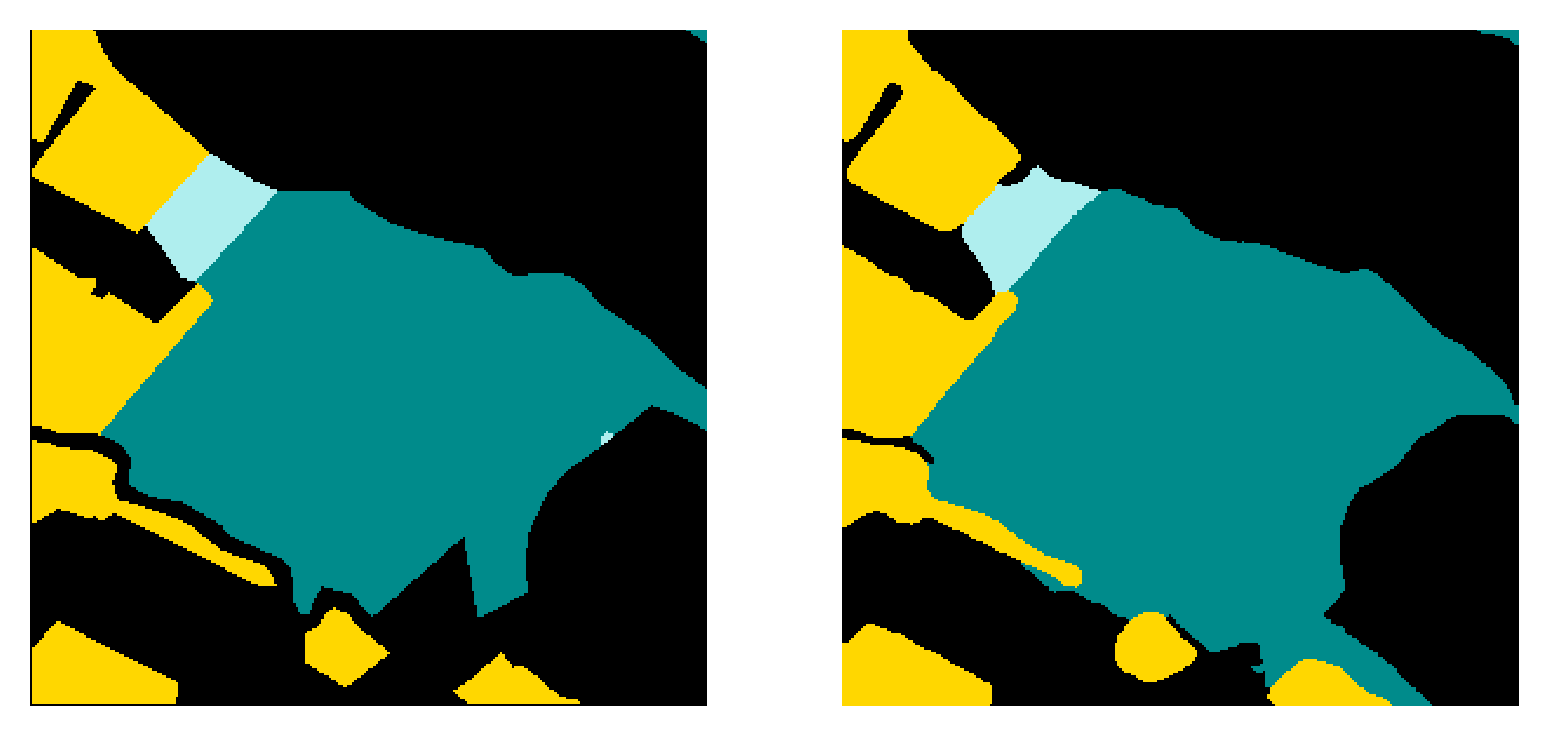

In [7]:
test_img_example = 88

fig, [ax1, ax2] = plt.subplots(1, 2)
label_cmap=ListedColormap(['black', 'gold', 'darkcyan', 'paleturquoise'])
ax1= show(labels[test_img_example], ax=ax1, vmin=0, vmax=3, cmap=label_cmap, interpolation='none')

ax2 = show(predictions[test_img_example], ax=ax2, vmin=0, vmax=3, cmap=label_cmap, interpolation='none')
ax1.axis('off')
ax2.axis('off')
#plt.colorbar()
plt.show()

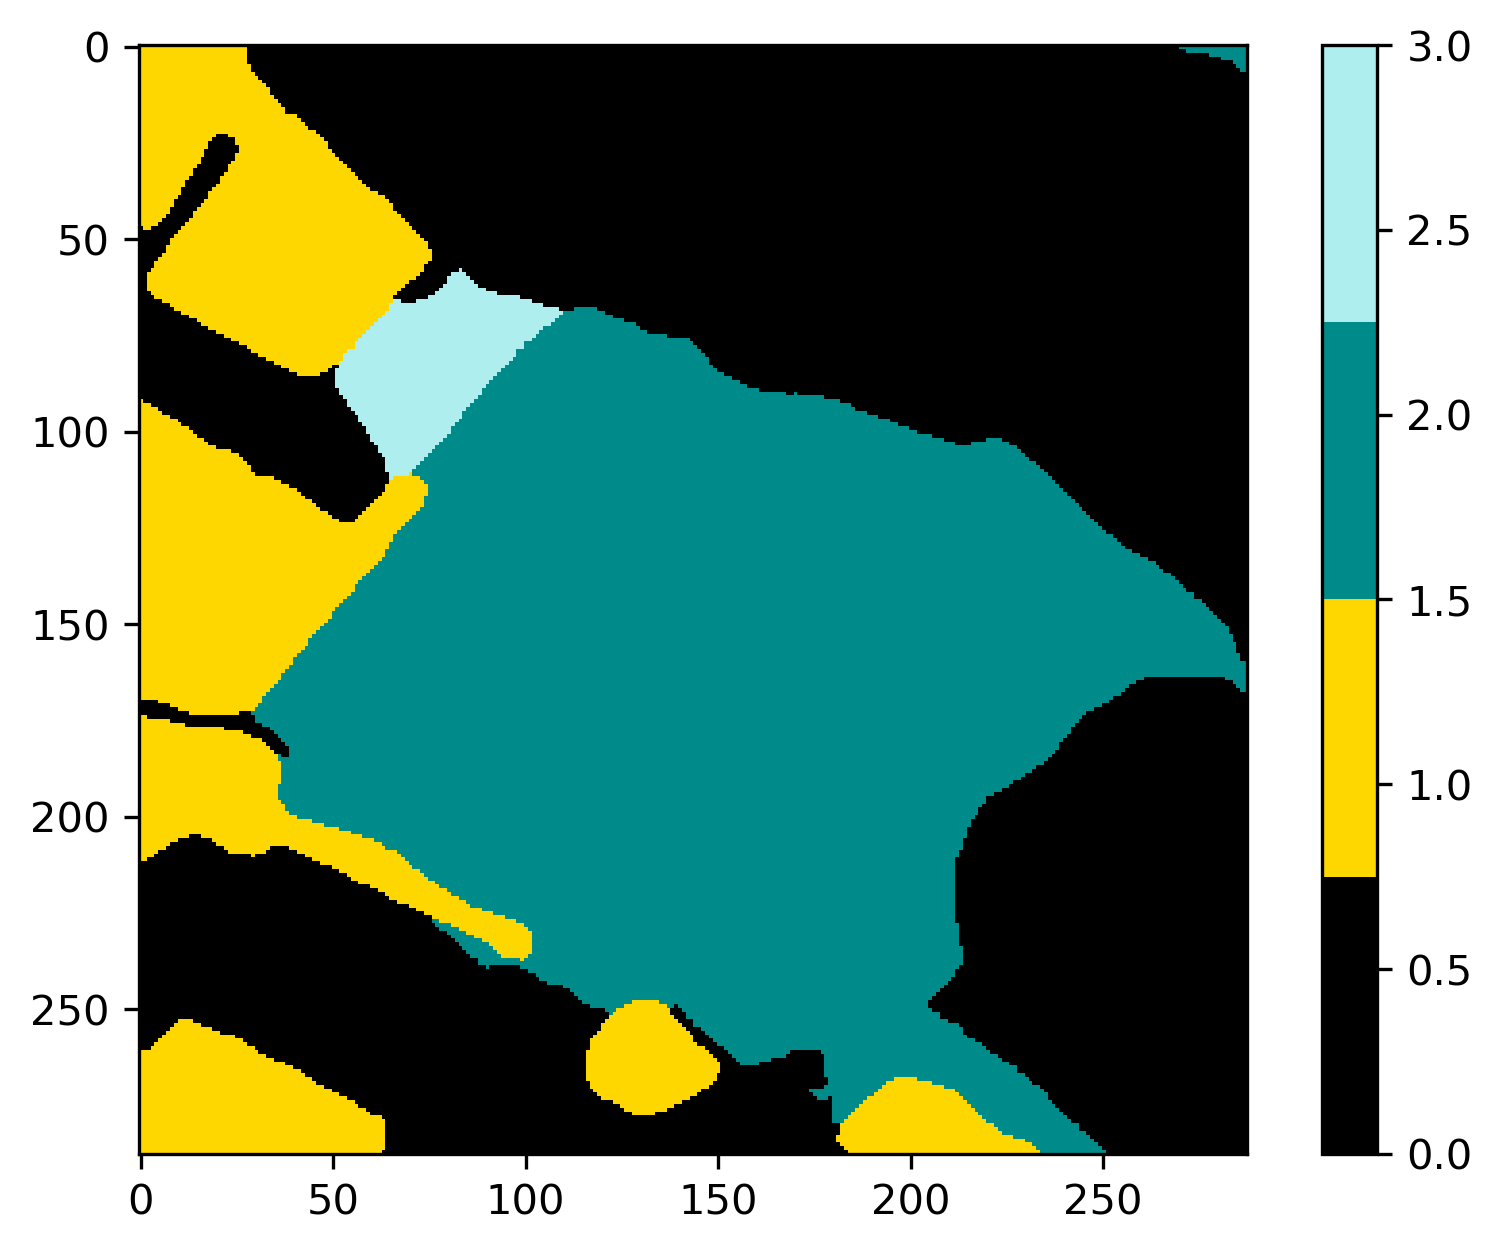

In [8]:
plt.imshow(predictions[test_img_example], vmin=0, vmax=3, cmap=label_cmap, interpolation='none')
plt.colorbar()
plt.show()

,median IoU small,median IoU medium,median IoU large,non empty median IoU,median IoU
1,0.666667,0.889723,0.935029,0.923088,1.0
2,0.0,0.756551,0.858482,0.772686,1.0
3,0.222742,0.691683,0.889474,0.734897,0.857941


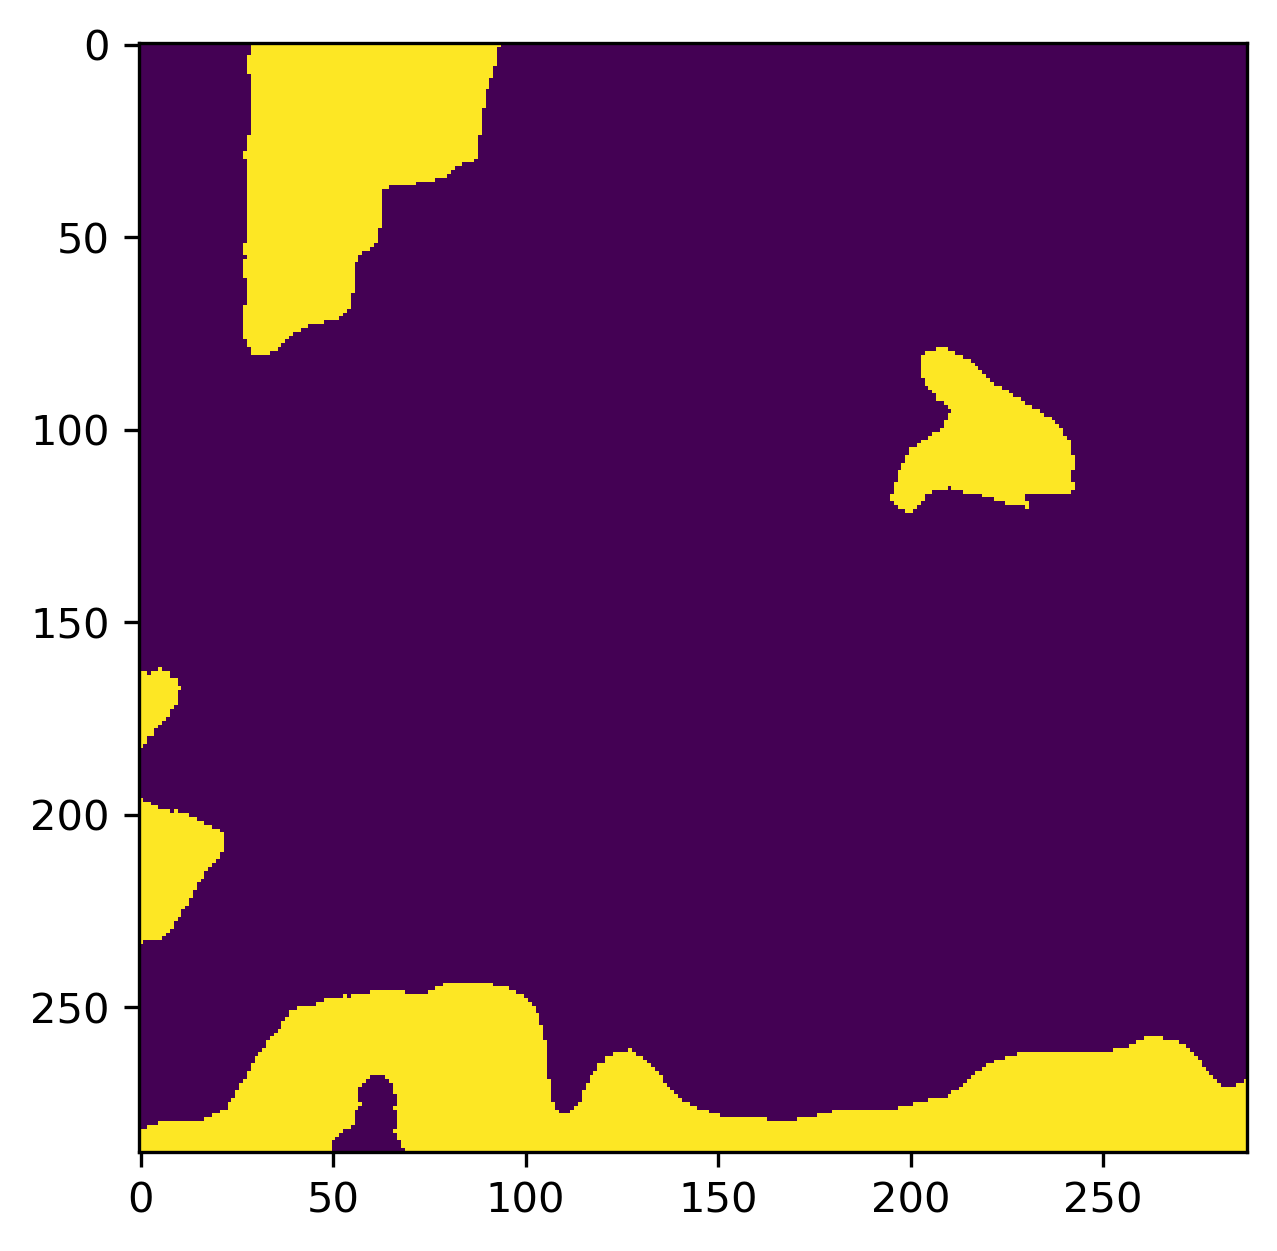

In [15]:
# Dataframe for holding the results
img_count = labels.shape[0]
large_size=96
medium_size = 32

worst_IoU = 1
worst_index = 0

bad_class = 2
bad_IoUs = []
size_bad_IoUs = []
IoU_results = pd.DataFrame(columns=['median IoU small', 'median IoU medium', 'median IoU large', 'non empty median IoU', 'median IoU'])
# Analysing the IoU for each class
for i in range(1, 4):
    class_labels = np.where(labels == i, 1, 0).astype('uint8')
    #label_masks = np.where(labels == i, 255, 0).astype('uint8')
    
    class_predictions = np.where(predictions == i, 1, 0).astype('uint8')
    #prediction_masks = np.where(labels == i, 255, 0).astype('uint8')

    # Size definitions from mscoco 
    IoUs = np.empty(img_count, dtype='float32')
    non_empty_IoUs = np.empty(img_count, dtype='float32')
    large_IoUs = np.empty(img_count, dtype='float32')
    medium_IoUs = np.empty(img_count, dtype='float32')
    small_IoUs = np.empty(img_count, dtype='float32')
    # And for each image
    for j in range(img_count):
        label = class_labels[j]
        prediction = class_predictions[j]
        IoUs[j] = image_IoU(prediction, label, keep_empty=True)
        non_empty_IoUs[j] = image_IoU(prediction, label, keep_empty=False)
        
        if i == bad_class:
            if IoUs[j] < 0.5:
                bad_IoUs.append(j)
        """
        # Finding the test image with worst IoU
        if i == 1:
            if worst_IoU > IoUs[j]:
                worst_IoU = IoUs[j]
                worst_index = j
        """
        
        # large features
        large_label = sieve(label, size=large_size**2)
        large_prediction = sieve(prediction, size=large_size**2)

        # Sieving also removes small gaps, this restores them
        large_label = np.where(label==0, 0, large_label)
        large_prediction = np.where(prediction==0, 0, large_prediction)
        
        # Medium features
        medium_label = sieve(label, size=medium_size**2)
        medium_prediction = sieve(prediction, size=medium_size**2)

        # Removing too large features from the sieved results
        medium_label = medium_label - large_label
        medium_prediction = medium_prediction - large_prediction

        medium_label = np.where(label==0, 0, medium_label)
        medium_prediction = np.where(prediction==0, 0, medium_prediction)

        # Small can just be derived from medium and large
        small_label = label - large_label - medium_label
        small_prediction = prediction - large_prediction - medium_prediction
        
        
        large_IoUs[j] = image_IoU(large_prediction, large_label, keep_empty=False)
        medium_IoUs[j] = image_IoU(medium_prediction, medium_label, keep_empty=False)
        small_IoUs[j] = image_IoU(small_prediction, small_label, keep_empty=False)

        if i == bad_class:
            if small_IoUs[j] < 0.1:
                size_bad_IoUs.append(j)
            
        if j == test_img_example and i ==1:
            plt.imshow(prediction)
    
    IoU_results.at[i, 'non empty median IoU'] = np.nanmedian(non_empty_IoUs)
    IoU_results.at[i, 'median IoU'] = np.nanmedian(IoUs)
    IoU_results.at[i, 'median IoU large'] = np.nanmedian(large_IoUs)
    IoU_results.at[i, 'median IoU medium'] = np.nanmedian(medium_IoUs)
    IoU_results.at[i, 'median IoU small'] = np.nanmedian(small_IoUs)

bad_IoUs = list(set(size_bad_IoUs)- set(bad_IoUs))
    
#print(bad_IoUs)
IoU_results

,mean IoU small,mean IoU medium,mean IoU large,non empty mean IoU,mean IoU
1,0.521226,0.704325,0.846711,0.887286,0.946312
2,0.193989,0.551331,0.779979,0.663001,0.858254
3,0.266064,0.547757,0.842024,0.632264,0.760306


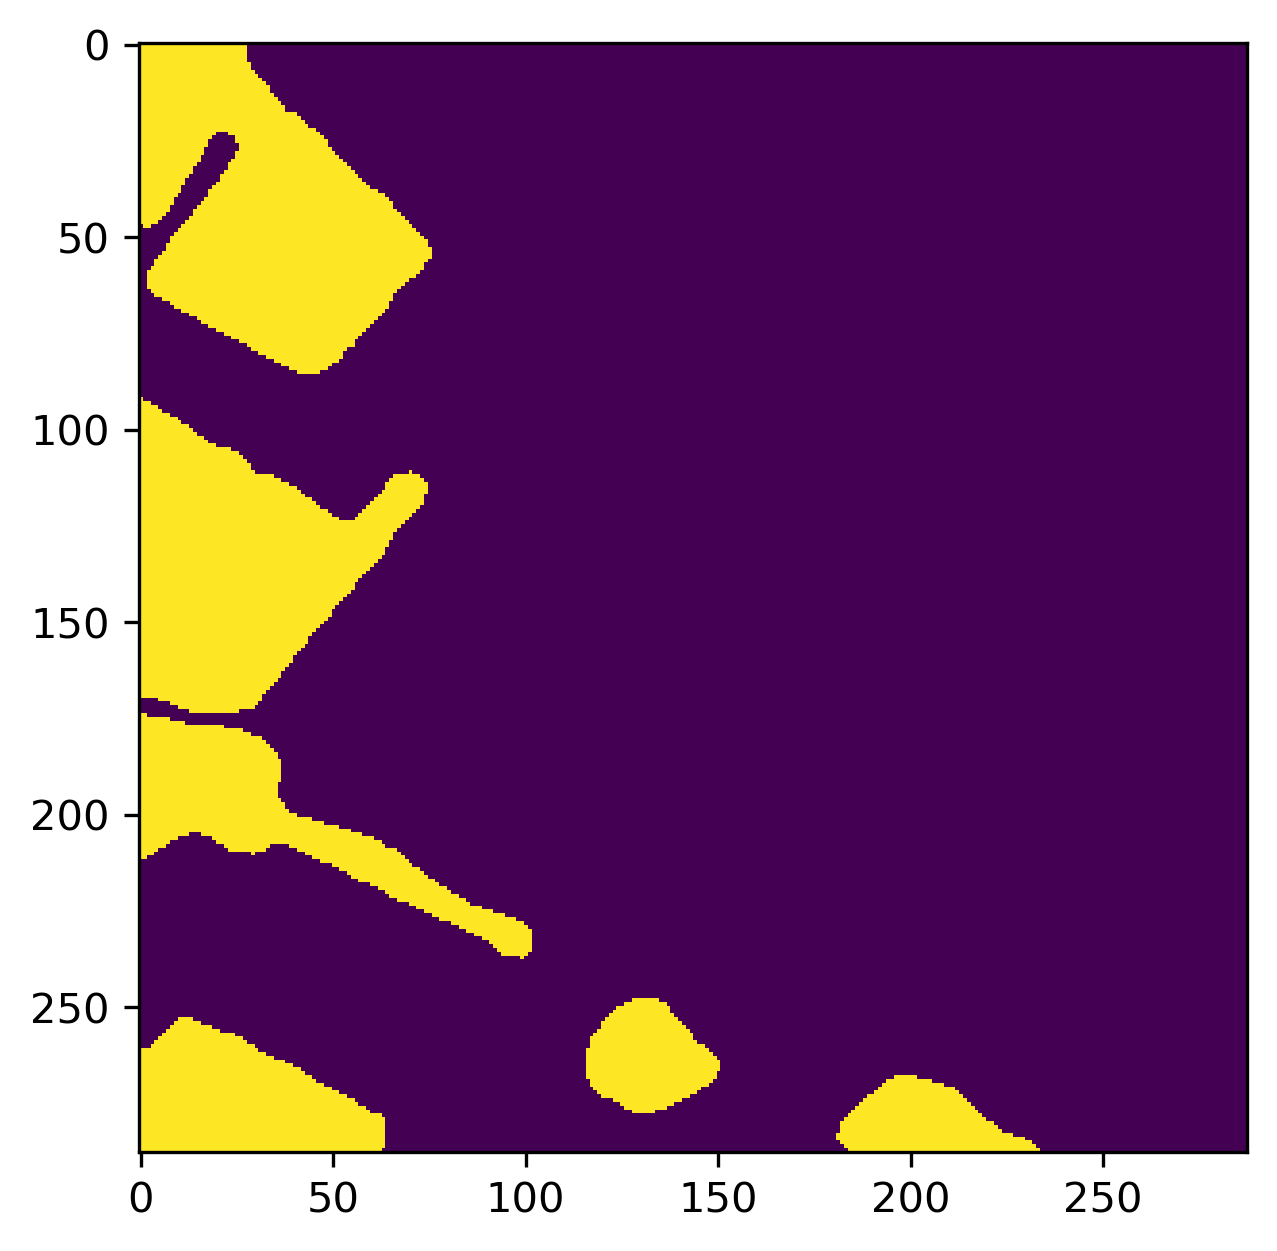

In [26]:
# Dataframe for holding the results
img_count = labels.shape[0]
large_size=96
medium_size = 32

worst_IoU = 1
worst_index = 0

bad_class = 2
bad_IoUs = []
size_bad_IoUs = []
IoU_results = pd.DataFrame(columns=['mean IoU small', 'mean IoU medium', 'mean IoU large', 'non empty mean IoU', 'mean IoU'])
# Analysing the IoU for each class
for i in range(1, 4):
    class_labels = np.where(labels == i, 1, 0).astype('uint8')
    #label_masks = np.where(labels == i, 255, 0).astype('uint8')
    
    class_predictions = np.where(predictions == i, 1, 0).astype('uint8')
    #prediction_masks = np.where(labels == i, 255, 0).astype('uint8')

    # Size definitions from mscoco 
    IoUs = np.empty(img_count, dtype='float32')
    non_empty_IoUs = np.empty(img_count, dtype='float32')
    large_IoUs = np.empty(img_count, dtype='float32')
    medium_IoUs = np.empty(img_count, dtype='float32')
    small_IoUs = np.empty(img_count, dtype='float32')
    # And for each image
    for j in range(img_count):
        label = class_labels[j]
        prediction = class_predictions[j]
        IoUs[j] = image_IoU(prediction, label, keep_empty=True)
        non_empty_IoUs[j] = image_IoU(prediction, label, keep_empty=False)
        
        if i == bad_class:
            if IoUs[j] < 0.5:
                bad_IoUs.append(j)
        """
        # Finding the test image with worst IoU
        if i == 1:
            if worst_IoU > IoUs[j]:
                worst_IoU = IoUs[j]
                worst_index = j
        """
        
        # large features
        large_label = sieve(label, size=large_size**2)
        large_prediction = sieve(prediction, size=large_size**2)

        # Sieving also removes small gaps, this restores them
        large_label = np.where(label==0, 0, large_label)
        large_prediction = np.where(prediction==0, 0, large_prediction)
        
        # Medium features
        medium_label = sieve(label, size=medium_size**2)
        medium_prediction = sieve(prediction, size=medium_size**2)

        # Removing too large features from the sieved results
        medium_label = medium_label - large_label
        medium_prediction = medium_prediction - large_prediction

        medium_label = np.where(label==0, 0, medium_label)
        medium_prediction = np.where(prediction==0, 0, medium_prediction)

        # Small can just be derived from medium and large
        small_label = label - large_label - medium_label
        small_prediction = prediction - large_prediction - medium_prediction
        
        
        large_IoUs[j] = image_IoU(large_prediction, large_label, keep_empty=False)
        medium_IoUs[j] = image_IoU(medium_prediction, medium_label, keep_empty=False)
        small_IoUs[j] = image_IoU(small_prediction, small_label, keep_empty=False)

        if i == bad_class:
            if small_IoUs[j] < 0.1:
                size_bad_IoUs.append(j)
            
        if j == test_img_example and i ==1:
            plt.imshow(prediction)
    
    IoU_results.at[i, 'non empty mean IoU'] = np.nanmean(non_empty_IoUs)
    IoU_results.at[i, 'mean IoU'] = np.nanmean(IoUs)
    IoU_results.at[i, 'mean IoU large'] = np.nanmean(large_IoUs)
    IoU_results.at[i, 'mean IoU medium'] = np.nanmean(medium_IoUs)
    IoU_results.at[i, 'mean IoU small'] = np.nanmean(small_IoUs)
    
    if i == 2:
        saved_result = medium_IoUs
    
bad_IoUs = list(set(size_bad_IoUs)- set(bad_IoUs))
    
#print(bad_IoUs)
IoU_results

,mean IoU small,mean IoU medium,mean IoU large,non empty mean IoU,mean IoU
1,0.521226,0.704325,0.846711,0.887286,0.946312
2,0.193989,0.551331,0.779979,0.663001,0.858254
3,0.266064,0.547757,0.842024,0.632264,0.760306


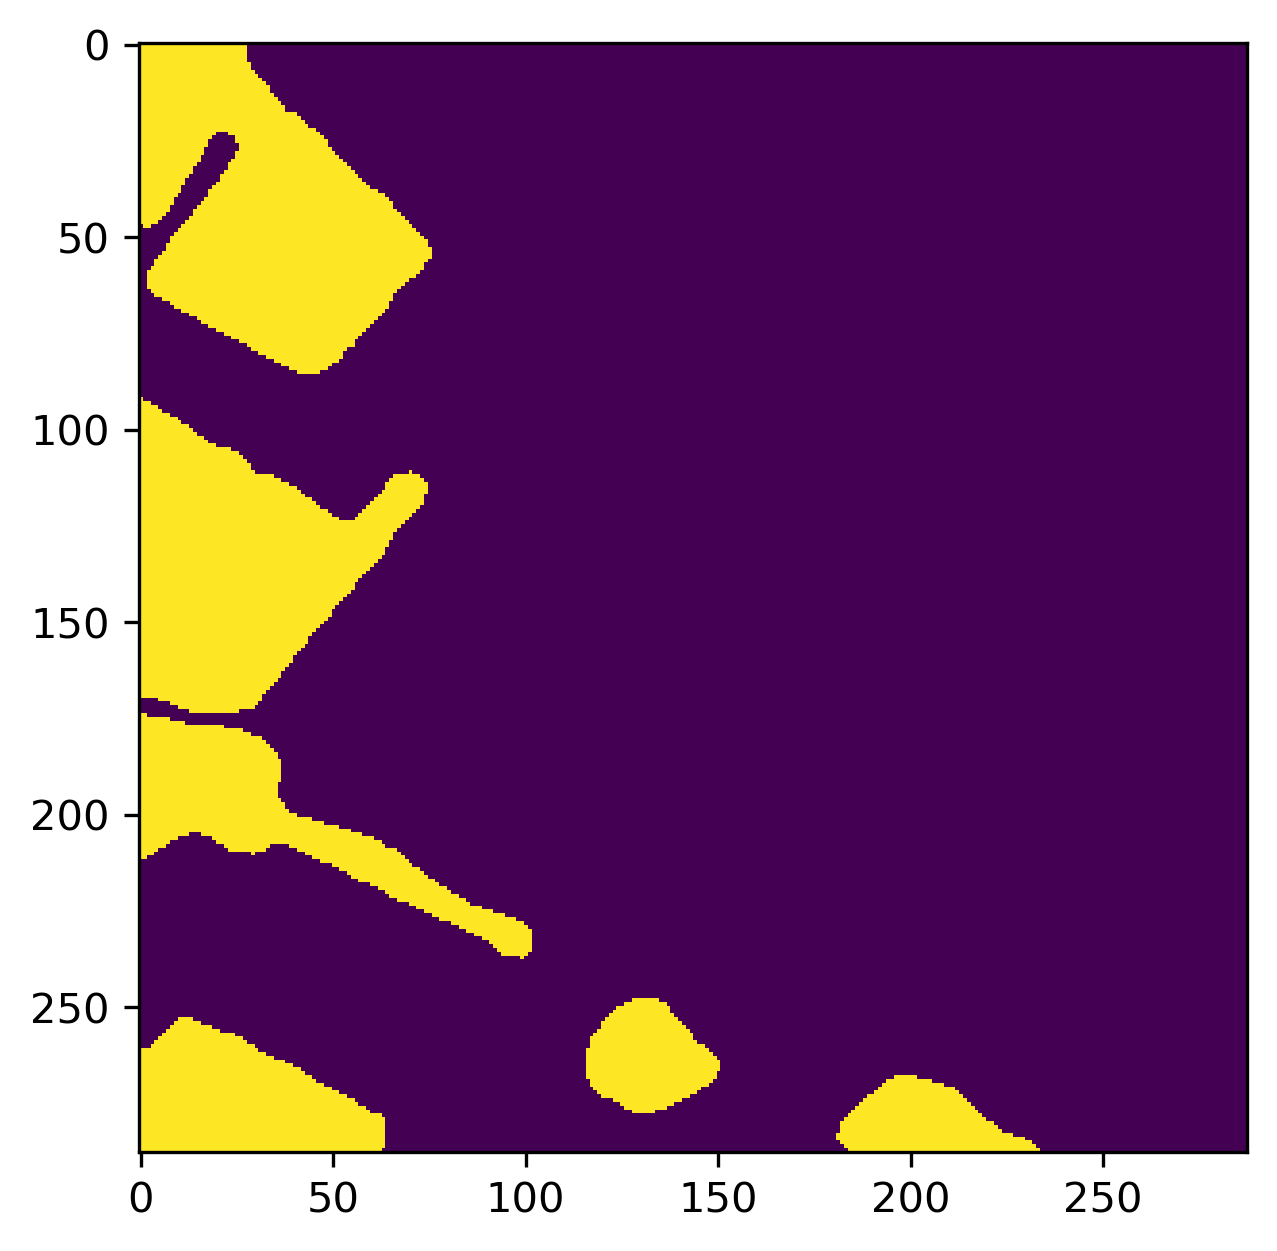

In [26]:
# Dataframe for holding the results
img_count = labels.shape[0]
large_size=96
medium_size = 32

worst_IoU = 1
worst_index = 0

bad_class = 2
bad_IoUs = []
size_bad_IoUs = []
IoU_results = pd.DataFrame(columns=['mean IoU small', 'mean IoU medium', 'mean IoU large', 'non empty mean IoU', 'mean IoU'])
# Analysing the IoU for each class
for i in range(1, 4):
    class_labels = np.where(labels == i, 1, 0).astype('uint8')
    #label_masks = np.where(labels == i, 255, 0).astype('uint8')
    
    class_predictions = np.where(predictions == i, 1, 0).astype('uint8')
    #prediction_masks = np.where(labels == i, 255, 0).astype('uint8')

    # Size definitions from mscoco 
    IoUs = np.empty(img_count, dtype='float32')
    non_empty_IoUs = np.empty(img_count, dtype='float32')
    large_IoUs = np.empty(img_count, dtype='float32')
    medium_IoUs = np.empty(img_count, dtype='float32')
    small_IoUs = np.empty(img_count, dtype='float32')
    # And for each image
    for j in range(img_count):
        label = class_labels[j]
        prediction = class_predictions[j]
        IoUs[j] = image_IoU(prediction, label, keep_empty=True)
        non_empty_IoUs[j] = image_IoU(prediction, label, keep_empty=False)
        
        if i == bad_class:
            if IoUs[j] < 0.5:
                bad_IoUs.append(j)
        """
        # Finding the test image with worst IoU
        if i == 1:
            if worst_IoU > IoUs[j]:
                worst_IoU = IoUs[j]
                worst_index = j
        """
        
        # large features
        large_label = sieve(label, size=large_size**2)
        large_prediction = sieve(prediction, size=large_size**2)

        # Sieving also removes small gaps, this restores them
        large_label = np.where(label==0, 0, large_label)
        large_prediction = np.where(prediction==0, 0, large_prediction)
        
        # Medium features
        medium_label = sieve(label, size=medium_size**2)
        medium_prediction = sieve(prediction, size=medium_size**2)

        # Removing too large features from the sieved results
        medium_label = medium_label - large_label
        medium_prediction = medium_prediction - large_prediction

        medium_label = np.where(label==0, 0, medium_label)
        medium_prediction = np.where(prediction==0, 0, medium_prediction)

        # Small can just be derived from medium and large
        small_label = label - large_label - medium_label
        small_prediction = prediction - large_prediction - medium_prediction
        
        
        large_IoUs[j] = image_IoU(large_prediction, large_label, keep_empty=False)
        medium_IoUs[j] = image_IoU(medium_prediction, medium_label, keep_empty=False)
        small_IoUs[j] = image_IoU(small_prediction, small_label, keep_empty=False)

        if i == bad_class:
            if small_IoUs[j] < 0.1:
                size_bad_IoUs.append(j)
            
        if j == test_img_example and i ==1:
            plt.imshow(prediction)
    
    #IoU_results.at[i, 'non empty mean IoU'] = np.nanmean(non_empty_IoUs)
    #IoU_results.at[i, 'mean IoU'] = np.nanmean(IoUs)
    #IoU_results.at[i, 'mean IoU large'] = np.nanmean(large_IoUs)
    #IoU_results.at[i, 'mean IoU medium'] = np.nanmean(medium_IoUs)
    #IoU_results.at[i, 'mean IoU small'] = np.nanmean(small_IoUs)
    
    if i == 2:
        saved_result = medium_IoUs
    
bad_IoUs = list(set(size_bad_IoUs)- set(bad_IoUs))
    
#print(bad_IoUs)
IoU_results

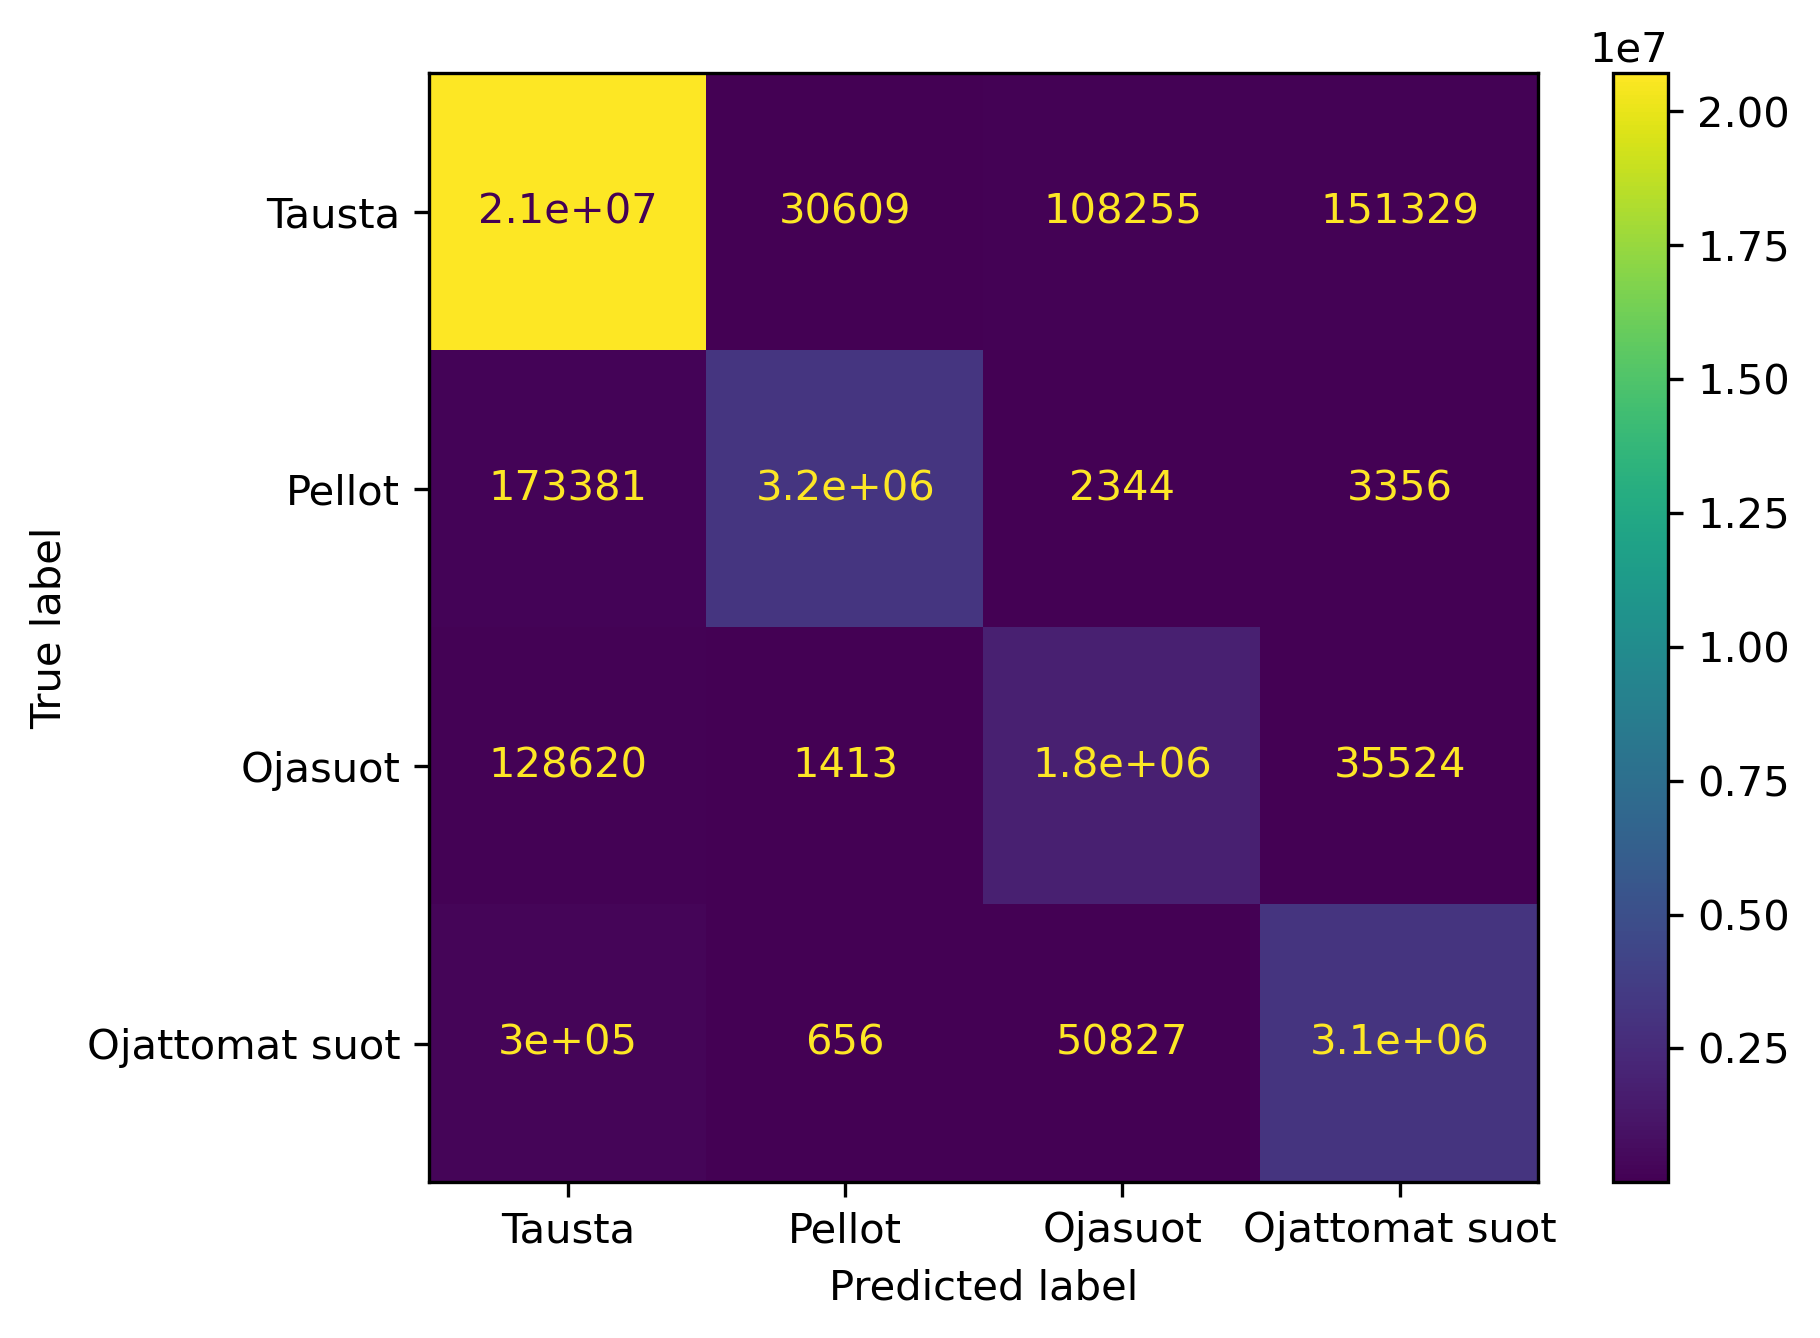

In [16]:
prediction_confusion_matrix = confusion_matrix(predictions.flatten(), labels.flatten())
disp = ConfusionMatrixDisplay(prediction_confusion_matrix, display_labels=["Tausta", "Pellot", "Ojasuot", "Ojattomat suot"])
disp.plot()
plt.show()

In [17]:
print(prediction_confusion_matrix)

[[20712185    30609   108255   151329]
 [  173381  3166773     2344     3356]
 [  128620     1413  1788737    35524]
 [  300683      656    50827  3122204]]


In [23]:
pred_zeroes = 0
label_zeroes = 0
both_zeroes = 0
for i in range(img_count):
    pred_count = np.count_nonzero(predictions[i])
    label_count = np.count_nonzero(labels[i])
    
    if pred_count == 0:
        pred_zeroes += 1
        
    if label_count == 0:
        label_zeroes += 1
        
    if label_count + pred_count == 0:
        both_zeroes += 1
print(pred_zeroes, label_zeroes, both_zeroes)

54 58 51


In [13]:
plt.imshow(field_predictions[test_img_example], vmin=0, vmax=3, cmap=label_cmap, interpolation='none')
plt.colorbar()
plt.show()

NameError: name 'field_predictions' is not defined

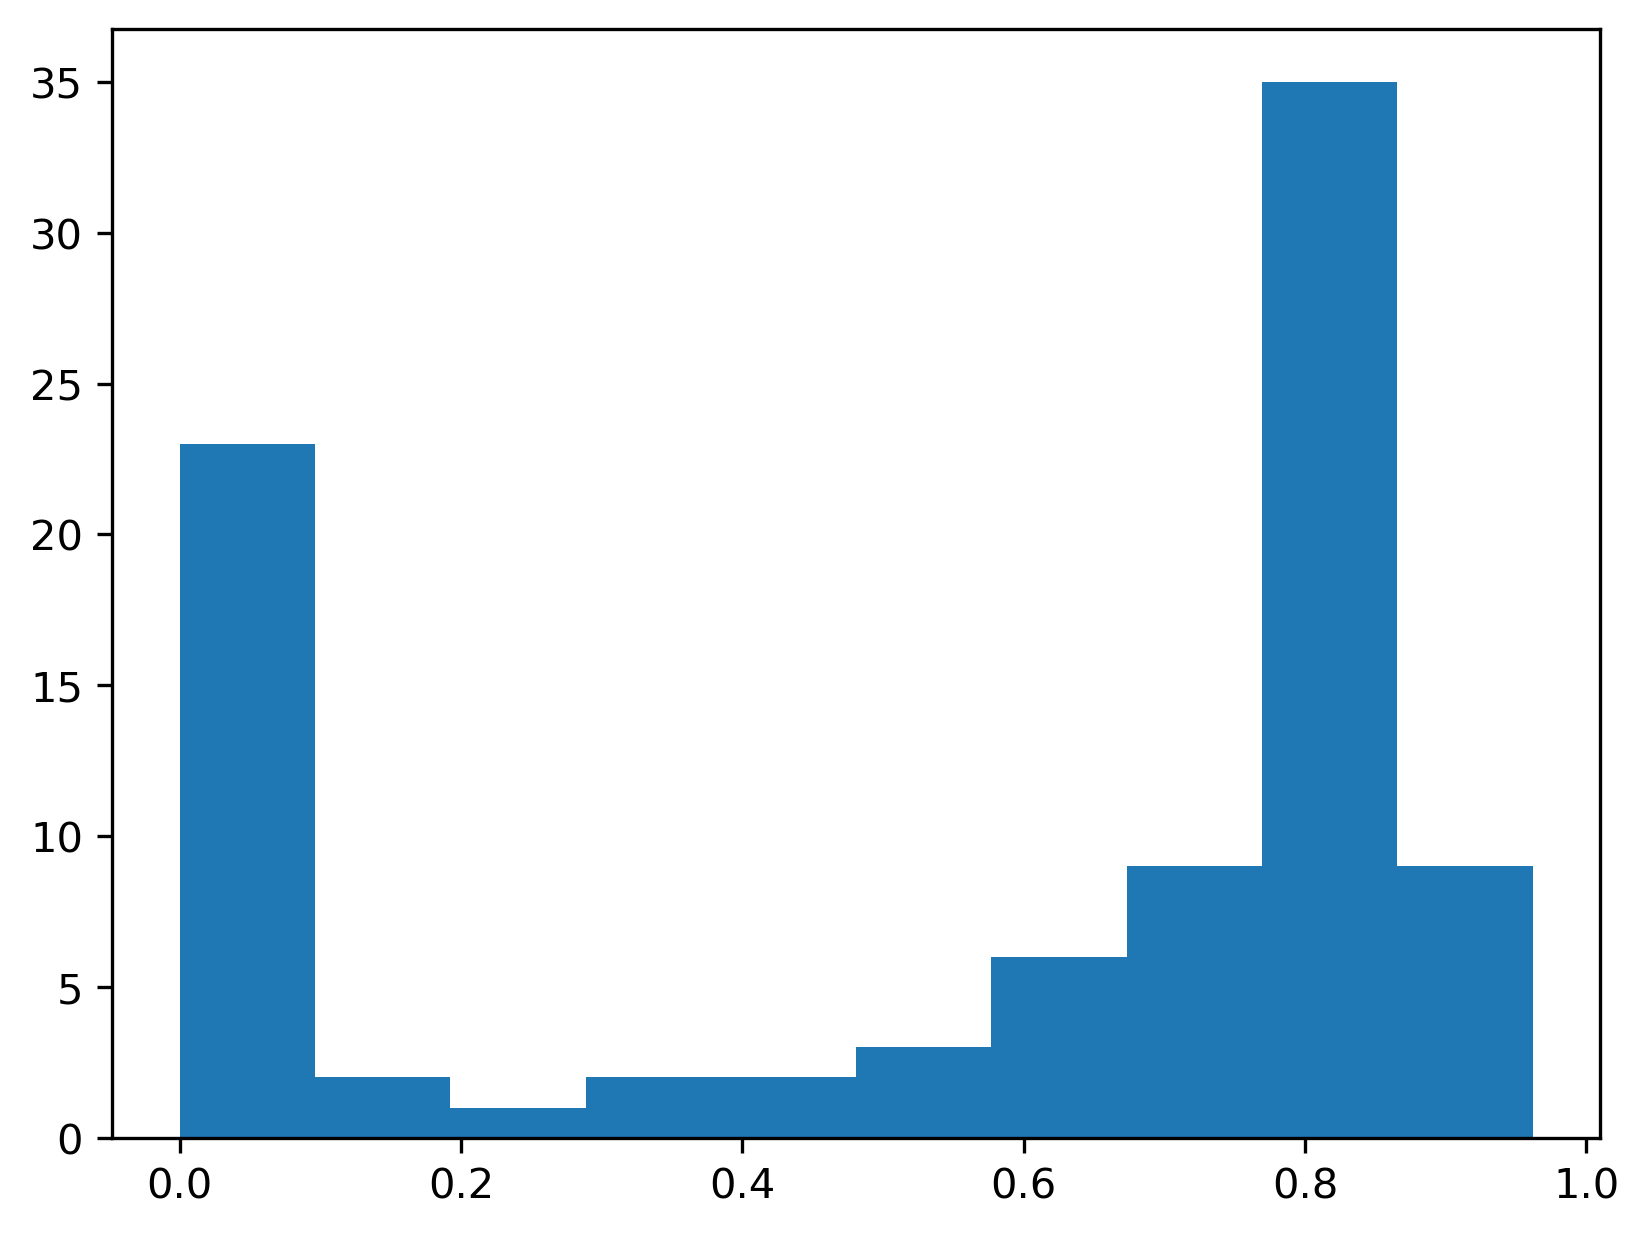

In [27]:
plot = plt.hist(saved_result)

In [ ]:
print(np.unique())